Импортируем необходимые библиотеки и датасет

In [269]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures

In [54]:
data = pd.read_csv('sberbank-russian-housing-market/train.csv', usecols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km', 'price_doc'])
# Обнаружено, что столбец 'additional_education_raion' используется дважды, причем, при выводе команд
# .shape, .head(), .info(), при построении матрицы корреляции и при расчете линейной регрессии дубликат не учитывается.
# В итоге, он был удален.

In [55]:
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,6.407578e+06,...,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,0.177975,5850000
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,9.589337e+06,...,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,0.273345,6000000
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.808270e+06,...,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,0.158072,5700000
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.258354e+07,...,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,0.236455,13100000
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,8.398461e+06,...,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,0.376838,16331452


Проводим EDA с упором на пропущенные значения и выбросы

In [56]:
# Для начала посмотрим общие параметры
data.shape

(30471, 44)

In [57]:
# Проверим наличие дубликатов и удалим им
data = data.drop_duplicates()
data.shape

(30145, 44)

Вышло 326 дубликатов

In [58]:
# Узнаем сколько пропущенных значений в датасете
data.isna().sum()

full_sq                                  0
life_sq                               6213
floor                                  159
max_floor                             9381
material                              9381
build_year                           13354
num_room                              9381
kitch_sq                              9381
state                                13334
area_m                                   0
raion_popul                              0
green_zone_part                          0
indust_part                              0
preschool_education_centers_raion        0
school_education_centers_raion           0
hospital_beds_raion                  14287
healthcare_centers_raion                 0
sport_objects_raion                      0
additional_education_raion               0
shopping_centers_raion                   0
office_raion                             0
ID_metro                                 0
metro_min_walk                          25
kindergarte

In [59]:
# Посмотрим общую статистику и подозрения на выбросы
data.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
count,30145.000000,23932.000000,29986.000000,20764.000000,20764.000000,1.679100e+04,20764.000000,20764.000000,16811.000000,3.014500e+04,...,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,3.014500e+04
mean,54.206767,34.395161,7.660608,12.540503,1.829416,3.073463e+03,1.910277,6.414853,2.109274,1.757215e+07,...,4.926908,13.297487,3.945736,1.148790,6.835684,3.911684,1.497122,1.997546,1.340223,7.136272e+06
std,38.167375,52.426560,5.314253,6.750545,1.482934,1.547322e+05,0.852167,28.353838,0.879615,2.055792e+07,...,4.802951,8.505275,3.441341,1.537081,6.724522,4.900822,2.247104,2.298743,3.042738,4.786121e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,2.081628e+06,...,0.000000,0.661366,0.003847,0.000000,0.000313,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.966000e+03,1.000000,1.000000,1.000000,7.128794e+06,...,2.045826,7.529625,1.539780,0.360188,2.196058,1.016728,0.482009,0.553122,0.285293,4.750000e+06
50%,49.000000,30.000000,6.000000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,1.032047e+07,...,3.953699,11.910442,2.908146,0.652673,4.293695,2.009000,0.834828,1.052999,0.492606,6.300000e+06
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,1.803644e+07,...,5.554481,16.588769,5.456627,1.318331,9.380269,5.372054,1.514768,2.943200,0.936324,8.300000e+06
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,2.060718e+08,...,54.080913,59.501648,41.103651,26.652505,84.862148,55.278225,26.259543,18.958933,47.394706,1.111111e+08


Складывается ощущение, что выбросов предостаточно, беглым взглядом бросается в глаза, что максимальная "жилая площадь" больше максимальной "полной площади", и "максимальная этажность" - 117 этажей, пробежавшись по интернету, было обнаружено, что в России нет зданий выше 100 этажей, далее, сомнительная дата постройки в строке max, как и в min и тд.

Для начала просто удалим все строки содержащие пустые значения и обучим модель на полученных значениях

In [60]:
datano_NA = data.dropna()

In [61]:
datano_NA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8574 entries, 8056 to 30470
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   full_sq                            8574 non-null   int64  
 1   life_sq                            8574 non-null   float64
 2   floor                              8574 non-null   float64
 3   max_floor                          8574 non-null   float64
 4   material                           8574 non-null   float64
 5   build_year                         8574 non-null   float64
 6   num_room                           8574 non-null   float64
 7   kitch_sq                           8574 non-null   float64
 8   state                              8574 non-null   float64
 9   area_m                             8574 non-null   float64
 10  raion_popul                        8574 non-null   int64  
 11  green_zone_part                    8574 non-null   f

In [62]:
X = datano_NA[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km']]
y = datano_NA['price_doc']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

-164.72499187691372

Полученный результат принесет сомнительную пользу.  
При изменении random_state полученное значение меняется от -390 до 58.  
При изменении размера тестовой выборки значение также меняется сильно.  
Из чего можно сделать вывод, что полученное значение очень сильно зависит от тех данных, на которых модель обучалась, следовательно, необходимо избавиться от выбросов.  
Но для начала заполним пустые значения.

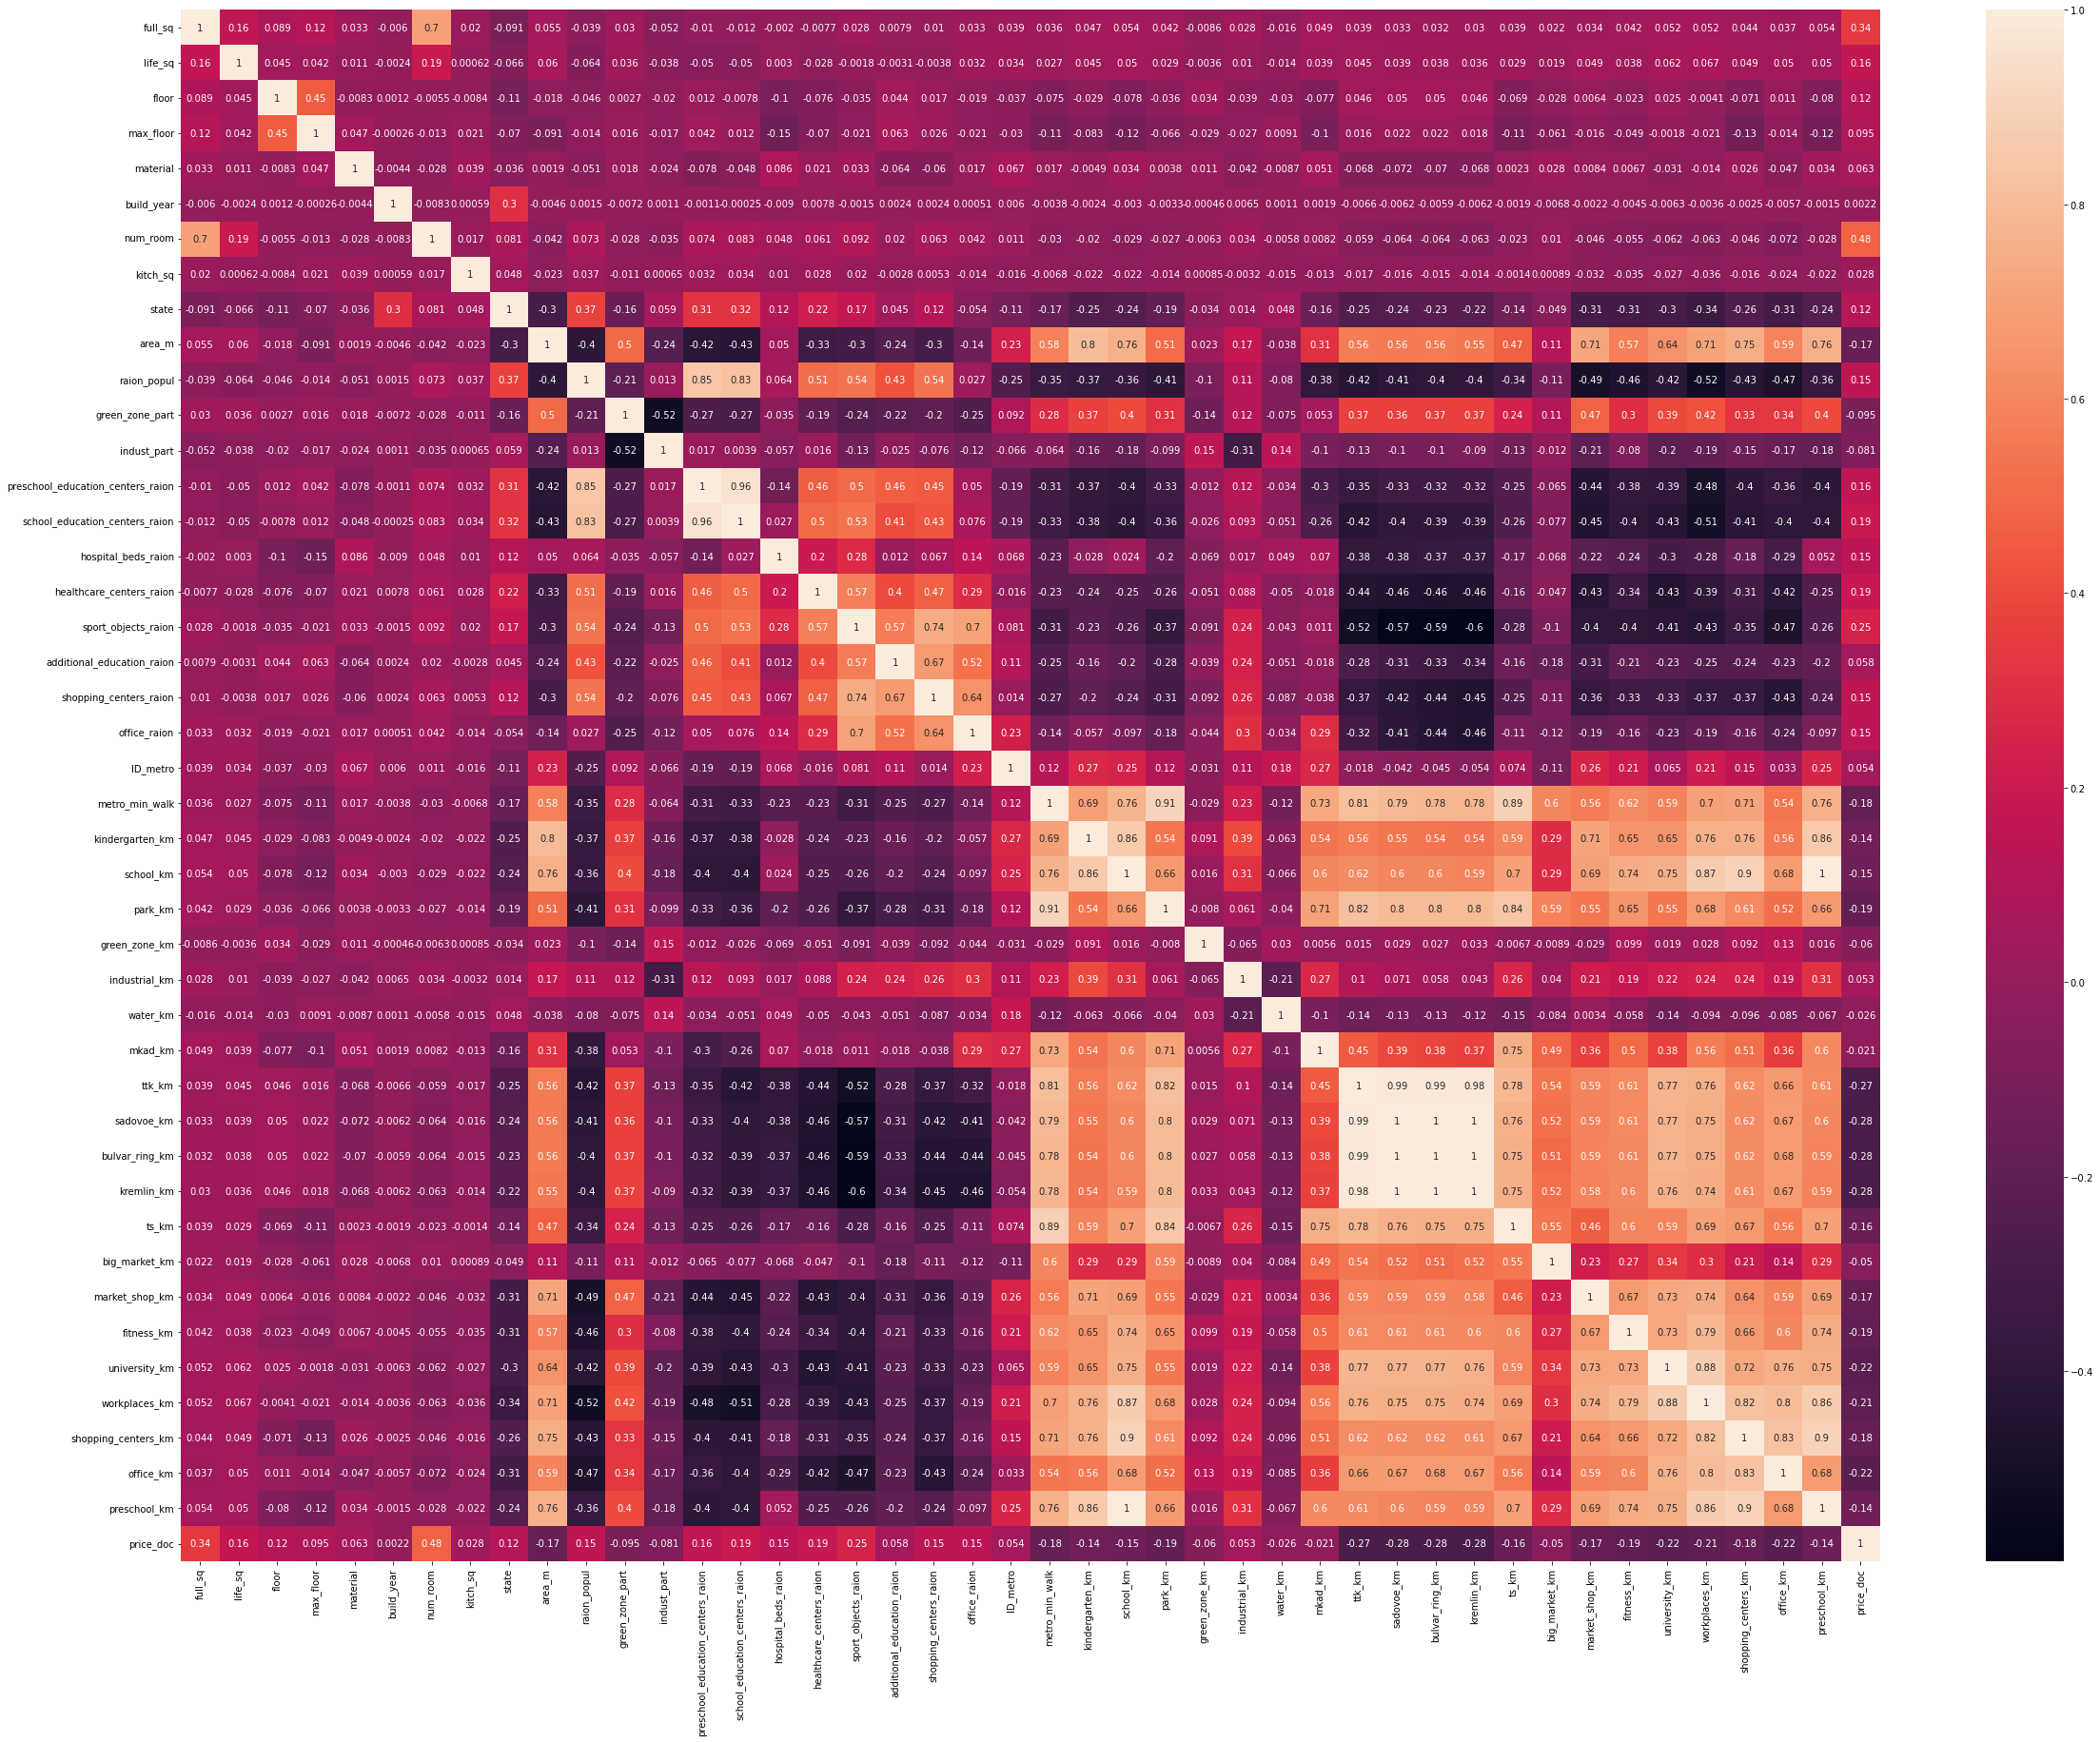

In [13]:
# Построим матрицу корреляции
plt.figure(figsize=(40,30))
sns.heatmap(data.corr(), annot=True)
plt.show()

Больше всего пропусков в столбце 'hospital_beds_raion' - 14287, сомневаюсь, что это действительно значимый параметр для оценки стоимости квартиры, хоть и коэффициент корреляции у него 0,15, что не является самым маленьким.  
Однако, при замене его на среднее, медиану и прочее, данные сильно меняются - Удалим данный столбец.

In [64]:
data_clean = data.drop(['hospital_beds_raion'], axis=1)

Меньше всего пропусков в столбце "metro_min_walk" - 25, заменим пропущенные значения на медиану.

In [65]:
med = data_clean['metro_min_walk'].median()
data_clean['metro_min_walk'] = data_clean['metro_min_walk'].fillna(med)

Идем далее, столбец "life_sq" - 6213 пропусков.

In [66]:
lsNAN = data_clean[data_clean['life_sq'].isna()]

In [67]:
lsNAN.isna().sum()

full_sq                                 0
life_sq                              6213
floor                                  25
max_floor                            2133
material                             2133
build_year                           5438
num_room                             2133
kitch_sq                             2133
state                                4539
area_m                                  0
raion_popul                             0
green_zone_part                         0
indust_part                             0
preschool_education_centers_raion       0
school_education_centers_raion          0
healthcare_centers_raion                0
sport_objects_raion                     0
additional_education_raion              0
shopping_centers_raion                  0
office_raion                            0
ID_metro                                0
metro_min_walk                          0
kindergarten_km                         0
school_km                         

Можно заполнить 4080 строк путем вычисления из общей площади (нет пропущенных значений), площади кухни (4080 заполненных строк)  
(full_sq - kitch_sq)

In [68]:
lsNAN.life_sq = lsNAN.full_sq - lsNAN.kitch_sq

C:\Users\cefeu\AppData\Local\Temp\ipykernel_27424\2506760066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsNAN.life_sq = lsNAN.full_sq - lsNAN.kitch_sq


In [69]:
data_clean['life_sq'].fillna(lsNAN['life_sq'], inplace = True)

Осталось еще 2133 пропусков...

Столбец "kitch_sq" - 9381 пропусков.

In [70]:
ksNAN = data_clean[data_clean['kitch_sq'].isna()]

Можно заполнить аналогичным способом, насколько это возможно, но в целом 9381 строка вызывает сомнения, быть может их просто удалить...

In [71]:
ksNAN.kitch_sq = ksNAN.full_sq - ksNAN.life_sq

C:\Users\cefeu\AppData\Local\Temp\ipykernel_27424\4282162908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksNAN.kitch_sq = ksNAN.full_sq - ksNAN.life_sq


In [72]:
data_clean['kitch_sq'].fillna(ksNAN['kitch_sq'], inplace = True)

In [73]:
data_clean.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
count,30145.000000,28012.000000,29986.000000,20764.000000,20764.000000,1.679100e+04,20764.000000,28012.000000,16811.000000,3.014500e+04,...,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,3.014500e+04
mean,54.206767,37.710089,7.660608,12.540503,1.829416,3.073463e+03,1.910277,9.426888,2.109274,1.757215e+07,...,4.926908,13.297487,3.945736,1.148790,6.835684,3.911684,1.497122,1.997546,1.340223,7.136272e+06
std,38.167375,50.012898,5.314253,6.750545,1.482934,1.547322e+05,0.852167,41.592222,0.879615,2.055792e+07,...,4.802951,8.505275,3.441341,1.537081,6.724522,4.900822,2.247104,2.298743,3.042738,4.786121e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,-720.000000,1.000000,2.081628e+06,...,0.000000,0.661366,0.003847,0.000000,0.000313,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,38.000000,21.000000,3.000000,9.000000,1.000000,1.966000e+03,1.000000,1.000000,1.000000,7.128794e+06,...,2.045826,7.529625,1.539780,0.360188,2.196058,1.016728,0.482009,0.553122,0.285293,4.750000e+06
50%,49.000000,32.000000,6.000000,12.000000,1.000000,1.979000e+03,2.000000,8.000000,2.000000,1.032047e+07,...,3.953699,11.910442,2.908146,0.652673,4.293695,2.009000,0.834828,1.052999,0.492606,6.300000e+06
75%,63.000000,45.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,11.000000,3.000000,1.803644e+07,...,5.554481,16.588769,5.456627,1.318331,9.380269,5.372054,1.514768,2.943200,0.936324,8.300000e+06
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,5304.000000,33.000000,2.060718e+08,...,54.080913,59.501648,41.103651,26.652505,84.862148,55.278225,26.259543,18.958933,47.394706,1.111111e+08


In [74]:
# Tеперь у нас появились кухни с отрицательными значениями метража, удалим их сразу как выбросы
data_clean['kitch_sq'] = np.where(data_clean['kitch_sq'] < 0, np.NaN, data_clean['kitch_sq'])

Осталось еще 2145 пропусков...  
Кухни с кухнями 0 метров оставляем, во-первых, потому, квартира может быть студией, где идет одна общая жилая площадь, во-вторых, насколько я понял, в представленном датасете данные не только о квартирах, вполне возможно какие-то офисные помещения и тд.

Берем build_year - 13354 пропусков. В полном датасете есть столбец sub_area, от него можно было бы оттолкнуться для определения ориентировочного года постройки, однако он у нас не доступен, поэтому как альтернатива можно воспользоваться ID_metro.  
Если заполнить пустые значения сразу, не удалив предварительно выбросы, получаются не очень красивые данные, поэтому для начала, удаляем выбросы, а потом заполняем пропуски

In [75]:
data_clean['build_year'] = np.where(data_clean['build_year'] > 2018, np.NaN, data_clean['build_year'])
data_clean['build_year'] = np.where(data_clean['build_year'] < 1690, np.NaN, data_clean['build_year'])

In [78]:
metro = data_clean.groupby('ID_metro').agg('mean').to_dict()
data_clean.build_year = data_clean.build_year.fillna(data_clean.ID_metro.map(metro['build_year']))

In [79]:
data_clean.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
count,30145.000000,28012.000000,29986.000000,20764.000000,20764.000000,30134.000000,20764.000000,28000.000000,16811.000000,3.014500e+04,...,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,30145.000000,3.014500e+04
mean,54.206767,37.710089,7.660608,12.540503,1.829416,1989.285920,1.910277,9.498036,2.109274,1.757215e+07,...,4.926908,13.297487,3.945736,1.148790,6.835684,3.911684,1.497122,1.997546,1.340223,7.136272e+06
std,38.167375,50.012898,5.314253,6.750545,1.482934,19.168803,0.852167,41.251421,0.879615,2.055792e+07,...,4.802951,8.505275,3.441341,1.537081,6.724522,4.900822,2.247104,2.298743,3.042738,4.786121e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,1691.000000,0.000000,0.000000,1.000000,2.081628e+06,...,0.000000,0.661366,0.003847,0.000000,0.000313,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,38.000000,21.000000,3.000000,9.000000,1.000000,1973.428571,1.000000,1.000000,1.000000,7.128794e+06,...,2.045826,7.529625,1.539780,0.360188,2.196058,1.016728,0.482009,0.553122,0.285293,4.750000e+06
50%,49.000000,32.000000,6.000000,12.000000,1.000000,1990.000000,2.000000,8.000000,2.000000,1.032047e+07,...,3.953699,11.910442,2.908146,0.652673,4.293695,2.009000,0.834828,1.052999,0.492606,6.300000e+06
75%,63.000000,45.000000,11.000000,17.000000,2.000000,2008.442509,2.000000,11.000000,3.000000,1.803644e+07,...,5.554481,16.588769,5.456627,1.318331,9.380269,5.372054,1.514768,2.943200,0.936324,8.300000e+06
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2018.000000,19.000000,5304.000000,33.000000,2.060718e+08,...,54.080913,59.501648,41.103651,26.652505,84.862148,55.278225,26.259543,18.958933,47.394706,1.111111e+08


Осталось 11 пропусков

Столбец state - 13334 пропусков. Та же самая картина, при заполнении пропусков, выбросы могут испортить картину, поэтому необходимо от них избавиться.

In [83]:
# Логично предположить, что 33 - выброс
data_clean.state.unique()

array([nan,  3.,  1.,  2.,  4., 33.])

In [84]:
data_clean['state'] = np.where(data_clean['state'] > 4, np.NaN, data_clean['state'])

Можно еще что-нибудь придумать с пропущенными значениями в столбцах floor и max_floor, привязать material к build_year, возможно, привязать state к целевой переменной price_doc, хотя корреляция у них почему-то очень маленькая, num_room к общей площади (хотя двухкомнатная квартира ОКАЗЫВАЕТСЯ бывает 35м (не знаю уж как "ПИК" умудрился), а бывает и 90м и более), но 25 тысяч $ тут уже не светят, поэтому, заполню все оставшиеся пропуски через SimpleImputer :)

In [90]:
simpI = SimpleImputer(missing_values = np.nan, strategy='mean')
simpI = SimpleImputer().fit_transform(data_clean)

In [95]:
data_cleaned = pd.DataFrame(simpI, columns = data_clean.columns)
data_cleaned

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
0,43.0,27.0,4.0,12.540503,1.829416,1976.890244,1.910277,16.0,2.107436,6.407578e+06,...,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,0.177975,5850000.0
1,34.0,19.0,3.0,12.540503,1.829416,1990.766187,1.910277,15.0,2.107436,9.589337e+06,...,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,0.273345,6000000.0
2,43.0,29.0,2.0,12.540503,1.829416,1978.987179,1.910277,14.0,2.107436,4.808270e+06,...,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,0.158072,5700000.0
3,89.0,50.0,9.0,12.540503,1.829416,2006.732955,1.910277,39.0,2.107436,1.258354e+07,...,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,0.236455,13100000.0
4,77.0,77.0,4.0,12.540503,1.829416,1943.785714,1.910277,0.0,2.107436,8.398461e+06,...,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,0.376838,16331452.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30140,44.0,27.0,7.0,9.000000,1.000000,1975.000000,2.000000,6.0,3.000000,1.005305e+07,...,1.833401,8.820934,0.812253,0.063432,2.236806,1.442576,0.325885,1.103579,0.349899,7400000.0
30141,86.0,59.0,3.0,9.000000,2.000000,1935.000000,4.000000,10.0,3.000000,7.307411e+06,...,3.215552,12.102735,1.825643,0.398831,0.672662,0.796851,0.540003,0.069986,0.362681,25000000.0
30142,45.0,44.0,10.0,20.000000,1.000000,2005.188889,1.000000,1.0,1.000000,2.553630e+07,...,3.729416,15.546028,6.433794,1.519553,12.893684,9.479093,1.806570,4.338453,1.234235,6970959.0
30143,64.0,32.0,5.0,15.000000,1.000000,2003.000000,2.000000,11.0,2.000000,6.050065e+06,...,3.781523,2.515959,2.711199,0.412813,1.982450,2.340429,1.108672,1.204798,0.130667,13500000.0


In [96]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30145 entries, 0 to 30144
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   full_sq                            30145 non-null  float64
 1   life_sq                            30145 non-null  float64
 2   floor                              30145 non-null  float64
 3   max_floor                          30145 non-null  float64
 4   material                           30145 non-null  float64
 5   build_year                         30145 non-null  float64
 6   num_room                           30145 non-null  float64
 7   kitch_sq                           30145 non-null  float64
 8   state                              30145 non-null  float64
 9   area_m                             30145 non-null  float64
 10  raion_popul                        30145 non-null  float64
 11  green_zone_part                    30145 non-null  flo

In [220]:
X = data_cleaned[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km']]
y = data_cleaned['price_doc']

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

-1.1593086952391847

Ситуация конечно улучшилась, но результат все равно плачевный. При разном random_state колеблется от -1,16 до 45.  
Избавимся от выбросов в оставшихся колонках.  
Посмотрим вручную некоторые, наиболее важные, по моему мнению, параметры, остальные удалим с помощью квантилей.

In [182]:
# Для начала взглянем на целевую переменную
data_cleaned.sort_values(by='price_doc').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
6689,60.0,44.0,5.0,12.540503,1.829416,1973.422594,1.910277,16.0,2.107436,1.051837e+07,...,0.955215,12.287708,2.712365,0.320627,2.644349,1.159019,0.618126,2.175588,0.507232,1005000.0
657,35.0,16.0,16.0,12.540503,1.829416,1981.076923,1.910277,19.0,2.107436,1.686153e+07,...,1.084029,16.663561,6.546668,0.501111,9.917234,1.035269,0.567130,0.690459,0.194160,1007000.0
10228,55.0,38.0,4.0,5.000000,2.000000,1964.000000,3.000000,6.0,2.000000,2.104405e+06,...,2.488176,15.129755,3.516524,0.171484,1.337980,0.300959,1.383605,1.604967,0.300959,1015000.0
26934,49.0,29.0,9.0,9.000000,2.000000,1989.000000,2.000000,8.0,3.000000,5.704502e+06,...,5.905004,9.352903,2.293462,1.305352,1.173094,0.728850,0.905132,0.417980,0.728850,1020000.0
6600,31.0,19.0,2.0,12.540503,1.829416,1979.110092,1.910277,12.0,2.107436,5.467178e+06,...,2.005416,5.285304,2.654402,1.494063,3.804425,3.419451,0.243147,0.632540,0.552650,1020000.0


In [177]:
data_cleaned.sort_values(by='price_doc').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
6222,206.0,128.0,2.0,12.540503,1.829416,1975.166667,1.910277,78.0,2.107436,13089795.79,...,2.695444,29.843020,3.221229,0.373393,4.851065,1.111248,0.790266,0.814473,0.741939,78802248.0
18826,184.0,85.0,10.0,47.000000,4.000000,2004.000000,1.000000,54.0,4.000000,18800000.10,...,4.421095,16.176380,6.043965,0.104265,1.692878,3.237853,0.359529,0.413282,0.883583,80777440.0
7315,185.0,66.0,33.0,12.540503,1.829416,1987.458333,1.910277,119.0,2.107436,18800000.10,...,4.421095,16.176380,6.043965,0.104265,1.692878,3.237853,0.359529,0.413282,0.883583,91066096.0
28017,220.0,144.0,3.0,5.000000,2.000000,1927.000000,9.000000,17.0,3.000000,11638050.15,...,4.068716,9.750911,3.010811,0.130117,0.988490,0.793147,0.832810,0.185520,0.345084,95122496.0
2108,55.0,31.0,12.0,12.540503,1.829416,1982.285714,1.910277,24.0,2.107436,8392316.21,...,4.184125,4.043604,4.238845,0.989694,1.655190,2.757239,0.496593,1.239758,0.432346,111111112.0


Предположим, самое дорогое помещение явный выброс, как и то, что дешевле миллиона.

In [179]:
data_cleaned = data_cleaned[(data_cleaned.price_doc < 100000000) & (data_cleaned.price_doc > 1000000)]

In [180]:
# Посмотрим что у нас с общей площадью
data_cleaned.sort_values(by='full_sq').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
24004,0.0,77.0,4.0,17.0,1.0,2005.188889,3.0,0.0,1.0,2.553630e+07,...,4.036914,16.024816,6.788676,1.884939,13.372472,9.660010,1.472893,4.445599,1.545730,8167508.0
17680,0.0,0.0,0.0,0.0,1.0,2008.442509,0.0,0.0,1.0,2.149409e+07,...,9.530140,14.703756,6.287163,0.680017,18.733878,8.802153,3.231528,5.072389,0.826052,4425000.0
22758,1.0,1.0,1.0,1.0,1.0,1981.698630,1.0,1.0,1.0,1.803644e+07,...,3.347832,20.706246,3.100941,0.651906,3.902200,1.333963,0.879739,1.233506,1.065852,27259184.0
16499,1.0,1.0,1.0,1.0,4.0,2008.442509,1.0,1.0,3.0,2.149409e+07,...,9.810357,14.444798,6.563669,0.978220,19.010384,9.089796,3.091415,5.084293,1.078636,7820575.0
23282,1.0,1.0,1.0,1.0,1.0,1994.690647,1.0,1.0,1.0,5.293465e+06,...,3.116335,10.066588,2.172405,0.824809,2.116757,1.335725,0.597565,0.244691,0.974059,11731927.0


In [181]:
data_cleaned.sort_values(by='full_sq').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
5856,634.0,38.0,3.0,12.540503,1.829416,1983.381910,1.910277,596.0,2.107436,5.646405e+06,...,5.354205,8.835486,2.557930,0.907818,6.794769,0.353390,0.192236,0.907818,0.353390,10200000.0
18082,634.0,634.0,3.0,17.000000,1.000000,2013.163158,2.000000,0.0,2.107436,1.139168e+07,...,5.013100,10.264218,5.439734,2.493236,8.837248,5.599071,2.215104,4.778766,0.214197,6213200.0
22497,637.0,637.0,18.0,19.000000,4.000000,2016.000000,2.000000,10.0,1.000000,7.307411e+06,...,3.757130,7.836658,1.092897,0.269716,2.180440,1.091507,0.107360,0.182194,0.269716,4725142.0
2769,729.0,44.0,12.0,12.540503,1.829416,1985.397059,1.910277,685.0,2.107436,1.127507e+07,...,2.324525,7.103961,0.685791,0.383331,1.614626,5.762451,0.269287,0.636908,0.426871,13250000.0
3502,5326.0,22.0,13.0,12.540503,1.829416,1977.984293,1.910277,5304.0,2.107436,1.479557e+07,...,1.927394,7.614379,3.169835,1.535936,7.517728,0.400044,1.896730,3.129234,0.699257,6868818.0


In [183]:
# Удаляем близкие к 0 значения и 5+ тысяч метров
data_cleaned = data_cleaned[(data_cleaned.full_sq < 1000) & (data_cleaned.full_sq > 1)]

In [189]:
# Посмотрим жилую площадь
data_cleaned.sort_values(by='life_sq').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
22964,77.0,0.0,16.0,22.0,1.0,2008.442509,3.0,0.0,1.0,7.878765e+06,...,12.349194,21.418622,3.405386,2.972129,23.149580,10.473497,0.557908,2.781995,3.545038,5615703.0
21355,84.0,0.0,8.0,0.0,1.0,2008.442509,3.0,1.0,1.0,6.677245e+07,...,6.087838,6.328276,10.533217,1.080227,10.987084,7.098232,4.909211,4.267267,3.419971,9377280.0
12505,119.0,0.0,9.0,0.0,1.0,2006.732955,5.0,0.0,1.0,1.258354e+07,...,0.678700,26.815150,0.952691,0.341012,9.825595,0.249131,0.179545,0.000000,0.249131,15254044.0
27092,62.0,0.0,13.0,17.0,1.0,1995.830769,2.0,62.0,1.0,1.132409e+07,...,0.949480,10.507131,1.320121,0.564069,6.335965,6.167764,0.638041,1.052999,0.044599,6489774.0
23422,37.0,0.0,9.0,19.0,1.0,2015.000000,1.0,0.0,3.0,7.878765e+06,...,12.349194,21.418622,3.405386,2.972129,23.149580,10.473497,0.557908,2.781995,3.545038,3572565.0


In [187]:
data_cleaned.sort_values(by='life_sq').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
23424,603.0,602.0,16.0,18.000000,1.000000,1992.242206,2.000000,1.000000,2.107436,1.084231e+07,...,18.058129,41.683695,2.336362,1.361867,2.330873,4.154584,0.862338,0.931016,0.648344,6572700.0
18082,634.0,634.0,3.0,17.000000,1.000000,2013.163158,2.000000,0.000000,2.107436,1.139168e+07,...,5.013100,10.264218,5.439734,2.493236,8.837248,5.599071,2.215104,4.778766,0.214197,6213200.0
22497,637.0,637.0,18.0,19.000000,4.000000,2016.000000,2.000000,10.000000,1.000000,7.307411e+06,...,3.757130,7.836658,1.092897,0.269716,2.180440,1.091507,0.107360,0.182194,0.269716,4725142.0
9459,82.0,802.0,5.0,12.540503,1.829416,1980.780952,1.910277,9.498036,2.107436,9.282439e+06,...,1.593704,12.258537,5.233650,1.274855,9.429381,1.144628,0.291261,0.300944,0.374914,12031350.0
13340,79.0,7478.0,8.0,17.000000,1.000000,2014.000000,3.000000,1.000000,1.000000,2.149409e+07,...,9.530140,14.703756,6.287163,0.680017,18.733878,8.802153,3.231528,5.072389,0.826052,7705000.0


In [193]:
# Удаляем максимальные значение и близкие к 0
data_cleaned = data_cleaned[(data_cleaned.life_sq < 800) & (data_cleaned.life_sq > 10)]

In [199]:
# Посмотрим этажи
data_cleaned.sort_values(by='floor').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
5014,157.0,75.0,0.0,12.540503,1.829416,2008.442509,1.910277,82.0,2.107436,8.699941e+07,...,23.962089,25.596684,7.869680,4.269785,30.255491,25.068104,16.402997,17.112701,18.265458,5000000.0
25128,81.0,39.0,0.0,12.000000,5.000000,2008.000000,2.000000,15.0,3.000000,4.133540e+07,...,15.133645,27.076725,5.454019,0.283484,28.807683,13.532830,3.781937,4.951841,4.933614,7650000.0
21637,160.0,160.0,0.0,3.000000,2.000000,2010.206030,3.000000,0.0,1.000000,7.307411e+06,...,3.757130,7.836658,1.092897,0.269716,2.180440,1.091507,0.107360,0.182194,0.269716,7267500.0
20941,74.0,74.0,0.0,0.000000,1.000000,2015.000000,2.000000,0.0,1.000000,6.677245e+07,...,4.881722,4.019261,6.149534,0.395077,8.678068,5.873590,4.255828,3.309481,3.840841,5802830.0
5255,181.0,79.0,0.0,12.540503,1.829416,2008.442509,1.910277,102.0,2.107436,8.699941e+07,...,24.034258,25.619413,7.892409,4.329653,30.278220,25.133070,16.403704,17.182098,18.314267,4500000.0


In [197]:
data_cleaned.sort_values(by='floor').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
6312,84.0,84.0,38.0,12.540503,1.829416,1979.110092,1.910277,0.0,2.107436,6050064.566,...,5.172935,4.763679,1.020481,1.014333,2.289203,4.203766,0.067996,0.979102,0.439948,9824000.0
21323,74.0,38.0,41.0,48.000000,4.000000,2013.000000,2.000000,5.0,3.000000,4800968.266,...,6.382780,6.607727,3.181282,0.295314,1.098037,1.303413,0.323051,0.113446,1.006318,14500000.0
29986,65.0,39.0,44.0,48.000000,4.000000,2000.000000,2.000000,5.0,4.000000,4800968.266,...,6.382780,6.607727,3.181282,0.295314,1.098037,1.303413,0.323051,0.113446,1.006318,8857680.0
2488,64.0,54.0,44.0,12.540503,1.829416,1994.520000,1.910277,10.0,2.107436,4800968.266,...,6.382780,6.607727,3.181282,0.295314,1.098037,1.303413,0.323051,0.113446,1.006318,13000000.0
23293,57.0,33.0,77.0,22.000000,1.000000,1986.000000,2.000000,10.0,3.000000,3326418.741,...,5.093557,6.221886,3.268157,0.489492,2.655779,2.848309,0.749363,0.310557,0.489763,13700000.0


In [201]:
# Удалим нулевые этажи и 77-ой этаж в 22х этажном здании
data_cleaned = data_cleaned[(data_cleaned.floor < 50) & (data_cleaned.floor > 0)]

In [203]:
data_cleaned.sort_values(by='max_floor').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
26597,84.0,84.0,10.0,0.0,1.0,2005.188889,3.0,0.0,2.107436,25536296.81,...,4.266105,16.109519,6.997373,2.085627,13.457175,9.891581,1.258676,4.329688,1.771738,9376203.0
20401,61.0,61.0,2.0,0.0,1.0,2008.442509,2.0,0.0,2.107436,66772450.69,...,6.087838,6.328276,10.533217,1.080227,10.987084,7.098232,4.909211,4.267267,3.419971,6500452.0
23818,72.0,72.0,5.0,0.0,1.0,2002.888889,2.0,0.0,2.107436,40366999.51,...,1.667530,8.281028,1.948185,0.844727,5.842595,5.247596,0.742543,0.743497,1.690124,7993361.0
23792,43.0,34.0,5.0,0.0,1.0,2008.442509,1.0,9.0,2.107436,66772450.69,...,6.087838,6.328276,10.533217,1.080227,10.987084,7.098232,4.909211,4.267267,3.419971,5945741.0
15760,58.0,58.0,10.0,0.0,1.0,2005.188889,0.0,0.0,2.107436,25536296.81,...,7.160048,21.181205,9.243037,4.872724,18.528862,11.458858,2.634358,4.909178,2.858928,6632021.0


In [204]:
data_cleaned.sort_values(by='max_floor').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
23728,135.0,59.0,9.0,57.0,4.0,2007.000000,3.0,22.0,4.000000,8.568431e+06,...,4.180221,16.442544,3.014062,0.000000,3.006711,0.210408,0.807907,0.272065,0.210408,56500000.0
20447,47.0,47.0,4.0,99.0,2.0,1975.166667,1.0,1.0,2.107436,1.308980e+07,...,1.576380,24.391233,0.839514,0.514682,5.375113,0.340327,0.511089,0.511089,0.331429,10238400.0
21450,71.0,71.0,5.0,99.0,6.0,2002.888889,2.0,9.0,2.107436,4.036700e+07,...,1.667530,8.281028,1.948185,0.844727,5.842595,5.247596,0.742543,0.743497,1.690124,8484365.0
21568,46.0,46.0,17.0,99.0,6.0,2008.442509,3.0,9.0,2.107436,6.677245e+07,...,5.426349,4.792372,6.922646,0.442563,9.451180,6.354706,4.502560,4.091140,3.382934,6670000.0
25643,63.0,63.0,8.0,117.0,1.0,2010.206030,2.0,1.0,1.000000,7.307411e+06,...,3.757130,7.836658,1.092897,0.269716,2.180440,1.091507,0.107360,0.182194,0.269716,7239838.0


In [205]:
# Удалим здания с 0 этажами и 99 и 117 этажные здания, таких в РФ нет.
data_cleaned = data_cleaned[(data_cleaned.max_floor < 60) & (data_cleaned.max_floor > 0)]

In [206]:
# Посмотрим количество комнат
data_cleaned.sort_values(by='num_room').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
24585,34.0,19.0,9.0,16.0,5.0,1982.000000,0.0,9.0,3.000000,9.282439e+06,...,2.643816,11.188896,4.029727,0.848260,12.919855,1.050794,0.561891,0.284228,1.050794,5400000.0
22901,84.0,84.0,3.0,15.0,2.0,2008.442509,0.0,0.0,1.000000,7.878765e+06,...,10.256880,17.926316,1.439764,3.654798,19.657274,8.594484,2.307309,0.704215,1.940044,7580000.0
27150,135.0,134.0,3.0,3.0,6.0,2013.000000,0.0,0.0,1.000000,1.631523e+07,...,17.593123,18.717327,4.242527,1.348050,23.376135,18.690225,11.079160,11.079160,12.829683,9308100.0
17868,112.0,112.0,3.0,3.0,1.0,1990.197531,0.0,0.0,1.000000,7.632940e+06,...,1.572189,15.773739,4.034559,0.989110,4.952442,3.232352,0.529696,0.837760,0.431915,7600002.0
16095,34.0,34.0,21.0,25.0,1.0,2001.393822,1.0,0.0,2.107436,6.677245e+07,...,4.840077,3.890219,6.020493,0.457578,8.549027,5.821730,4.204569,3.243768,3.815422,4396000.0


In [207]:
data_cleaned.sort_values(by='num_room').tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
28017,220.0,144.0,3.0,5.0,2.0,1927.0,9.0,17.0,3.0,1.163805e+07,...,4.068716,9.750911,3.010811,0.130117,0.988490,0.793147,0.832810,0.185520,0.345084,95122496.0
28857,59.0,33.0,20.0,22.0,1.0,2000.0,10.0,10.0,3.0,1.175477e+07,...,6.751180,1.686284,1.825114,0.330653,2.237006,0.364635,0.643666,0.444745,0.229004,11000000.0
17515,58.0,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,2.0,1.084231e+07,...,19.899288,45.019019,1.677437,0.396594,4.718412,3.621474,0.554538,1.039221,0.250213,6000000.0
26413,51.0,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,3.0,6.050065e+06,...,4.391505,4.891840,2.047915,0.218618,2.965958,3.572781,0.687470,0.341297,0.129363,13150000.0
11429,40.0,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,3.0,2.553630e+07,...,5.908985,17.652473,9.188754,3.752107,15.000129,11.269663,0.412866,4.581006,1.063754,2630000.0


In [208]:
# Удаляем 0 комнат и то, что выше 9, потому что сомнительно такое количество комнат в помещениях площадью 40-60м
data_cleaned = data_cleaned[(data_cleaned.num_room < 10) & (data_cleaned.num_room > 0)]

In [211]:
# Посмотрим площадь кухни
data_cleaned.sort_values(by='kitch_sq').head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
23141,61.0,61.0,3.0,22.000000,1.000000,2005.188889,2.000000,0.0,1.000000,2.553630e+07,...,4.188174,15.878202,7.006589,1.992371,13.225858,9.848053,1.350868,4.287295,1.692061,7154065.0
4650,56.0,56.0,10.0,12.540503,1.829416,2008.442509,1.910277,0.0,2.107436,5.299528e+07,...,13.011139,11.910442,7.480514,5.980372,16.569250,13.611344,7.937008,7.937008,7.671322,4465176.0
4652,42.0,42.0,2.0,12.540503,1.829416,1979.944056,1.910277,0.0,2.107436,6.677245e+07,...,4.307816,5.547796,7.560709,1.445152,11.471817,4.826297,3.543757,4.322574,2.883598,3452200.0
9615,40.0,40.0,12.0,12.540503,1.829416,2008.442509,1.910277,0.0,2.107436,7.878765e+06,...,10.474499,19.976570,4.913698,1.752290,21.707528,8.603435,1.744620,3.195432,1.559477,3410402.0
14036,72.0,72.0,23.0,25.000000,1.000000,2013.163158,2.000000,0.0,2.107436,1.139168e+07,...,5.013100,10.264218,5.439734,2.493236,8.837248,5.599071,2.215104,4.778766,0.214197,6906500.0


In [214]:
data_cleaned.sort_values(by='kitch_sq').tail(20)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc
28124,96.0,96.0,22.0,25.000000,1.000000,2016.000000,3.000000,96.0,1.000000,3.497819e+06,...,1.137624,9.767950,3.866439,0.415320,2.552459,1.250806,1.384182,0.677857,0.316634,15765120.0
28683,50.0,30.0,4.0,17.000000,1.000000,2014.000000,2.000000,97.0,1.000000,1.139168e+07,...,4.159095,10.149622,4.420876,2.916679,9.320418,4.795588,1.749300,4.858872,0.359443,6500000.0
1301,291.0,189.0,2.0,12.540503,1.829416,1994.262295,1.910277,102.0,2.107436,7.792845e+06,...,5.953936,23.667168,7.378440,0.855111,12.631583,5.606251,0.947211,2.791192,0.710465,7750000.0
6055,211.0,108.0,1.0,12.540503,1.829416,1994.262295,1.910277,103.0,2.107436,7.792845e+06,...,5.888986,23.746861,7.458133,0.790092,12.711276,6.455104,0.191669,2.097574,0.230635,16529487.0
27690,112.0,112.0,3.0,3.000000,1.000000,2015.000000,3.000000,112.0,3.000000,7.632940e+06,...,1.572189,15.773739,4.034559,0.989110,4.952442,3.232352,0.529696,0.837760,0.431915,10500000.0
27625,112.0,112.0,3.0,3.000000,1.000000,2015.000000,3.000000,112.0,3.000000,6.677245e+07,...,3.875306,2.570645,5.148790,3.950252,7.677324,3.839958,2.752079,0.366671,3.353511,10950065.0
19780,112.0,112.0,3.0,3.000000,1.000000,2015.000000,3.000000,112.0,3.000000,6.677245e+07,...,3.875306,2.570645,5.148790,3.950252,7.677324,3.839958,2.752079,0.366671,3.353511,8200031.0
7315,185.0,66.0,33.0,12.540503,1.829416,1987.458333,1.910277,119.0,2.107436,1.880000e+07,...,4.421095,16.176380,6.043965,0.104265,1.692878,3.237853,0.359529,0.413282,0.883583,91066096.0
8772,123.0,123.0,3.0,10.000000,2.000000,2013.000000,3.000000,123.0,3.000000,2.149409e+07,...,10.038436,9.987977,10.376731,4.152958,14.646785,10.847469,6.451039,7.735508,3.175433,8287230.0
8652,226.0,94.0,20.0,12.540503,1.829416,1978.656000,1.910277,132.0,2.107436,5.704502e+06,...,4.476982,8.330019,1.136849,0.000000,1.362255,0.575921,0.874923,0.719388,0.575921,13200000.0


In [216]:
# Предположим, что кухни может и не быть, поэтому 0 оставляем, но, даже если учесть, что здесь могут быть помещения 
# ресторанов, то крайне сомневаюсь, что там необходимы настолько большие кухни
data_cleaned = data_cleaned[data_cleaned.kitch_sq < 200]

In [221]:
# Посмотрим, что получится сейчас
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5334467741348367

Значительный прогресс, удалим выбросы в остальных колонках и посмотрим, что из этого выйдет:

In [230]:
for i in X:
    upper_bound = data_cleaned[i].quantile(q=0.95)
    lower_bound = data_cleaned[i].quantile(q=0.05)
    data_cleaned1 = data_cleaned.loc[(data_cleaned[i] < upper_bound) & (data_cleaned[i] > lower_bound)]

In [233]:
X = data_cleaned1[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km']]
y = data_cleaned1['price_doc']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5438341688755147

Cтало еще чуть лучше, сгенерируем новые признаки:

In [245]:
# Кластеризуем по отдаленности от клучевых точек
data_new = data_cleaned1.copy()
kmeans = KMeans(n_clusters=5) 
cluster = kmeans.fit_predict(data_cleaned1[['mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km']])
data_new['district'] = cluster
#data_new = data_new.drop(['mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km'], axis=1)
data_new.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc,district
0,43.0,27.0,4.0,12.540503,1.829416,1976.890244,1.910277,16.0,2.107436,6.407578e+06,...,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,0.177975,5850000.0,0
1,34.0,19.0,3.0,12.540503,1.829416,1990.766187,1.910277,15.0,2.107436,9.589337e+06,...,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,0.273345,6000000.0,4
2,43.0,29.0,2.0,12.540503,1.829416,1978.987179,1.910277,14.0,2.107436,4.808270e+06,...,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,0.158072,5700000.0,4
3,89.0,50.0,9.0,12.540503,1.829416,2006.732955,1.910277,39.0,2.107436,1.258354e+07,...,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,0.236455,13100000.0,1
4,77.0,77.0,4.0,12.540503,1.829416,1943.785714,1.910277,0.0,2.107436,8.398461e+06,...,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,0.376838,16331452.0,2


In [248]:
X = data_new[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km', 'district']]
y = data_new['price_doc']

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5438274920255236

Лучше не стало, кластеризуем по социальной инфраструктуре:

In [254]:
kmeans = KMeans(n_clusters=5) 
cluster = kmeans.fit_predict(data_new[['green_zone_part', 'healthcare_centers_raion', 'sport_objects_raion', 'shopping_centers_raion', 'metro_min_walk']])
data_new['social'] = cluster
data_new.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc,district,social
0,43.0,27.0,4.0,12.540503,1.829416,1976.890244,1.910277,16.0,2.107436,6.407578e+06,...,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,0.177975,5850000.0,0,0
1,34.0,19.0,3.0,12.540503,1.829416,1990.766187,1.910277,15.0,2.107436,9.589337e+06,...,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,0.273345,6000000.0,4,0
2,43.0,29.0,2.0,12.540503,1.829416,1978.987179,1.910277,14.0,2.107436,4.808270e+06,...,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,0.158072,5700000.0,4,0
3,89.0,50.0,9.0,12.540503,1.829416,2006.732955,1.910277,39.0,2.107436,1.258354e+07,...,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,0.236455,13100000.0,1,3
4,77.0,77.0,4.0,12.540503,1.829416,1943.785714,1.910277,0.0,2.107436,8.398461e+06,...,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,0.376838,16331452.0,2,3


In [255]:
X = data_new[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km', 'district', 'social']]
y = data_new['price_doc']

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5439507305722819

Небольшое улучшение, попробуем кластеризацию отдаленности объектов образования:

In [257]:
kmeans = KMeans(n_clusters=5) 
cluster = kmeans.fit_predict(data_new[['preschool_education_centers_raion', 'school_education_centers_raion', 
'additional_education_raion', 'kindergarten_km','school_km', 'university_km', 'preschool_km']])
data_new['education'] = cluster
data_new.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc,district,social,education
0,43.0,27.0,4.0,12.540503,1.829416,1976.890244,1.910277,16.0,2.107436,6.407578e+06,...,0.485841,6.715026,0.884350,0.648488,0.637189,0.177975,5850000.0,0,0,0
1,34.0,19.0,3.0,12.540503,1.829416,1990.766187,1.910277,15.0,2.107436,9.589337e+06,...,0.668364,1.852560,0.686252,0.519311,0.688796,0.273345,6000000.0,4,0,1
2,43.0,29.0,2.0,12.540503,1.829416,1978.987179,1.910277,14.0,2.107436,4.808270e+06,...,0.733101,0.841254,1.510089,1.486533,1.543049,0.158072,5700000.0,4,0,1
3,89.0,50.0,9.0,12.540503,1.829416,2006.732955,1.910277,39.0,2.107436,1.258354e+07,...,0.623484,10.903161,0.622272,0.599914,0.934273,0.236455,13100000.0,1,3,0
4,77.0,77.0,4.0,12.540503,1.829416,1943.785714,1.910277,0.0,2.107436,8.398461e+06,...,0.220288,0.991683,0.892668,0.429052,0.077901,0.376838,16331452.0,2,3,1


In [258]:
X = data_new[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km', 'district', 'social', 'education']]
y = data_new['price_doc']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5438740621465632

Никакого улучшения, попробуем ввести категориальную переменнную первый этаж или нет:

In [266]:
data_new['first_floor'] = data_new['floor'].map(lambda x: 1 if x==1 else 0)
data_new.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,university_km,workplaces_km,shopping_centers_km,office_km,preschool_km,price_doc,district,social,education,first_floor
0,43.0,27.0,4.0,12.540503,1.829416,1976.890244,1.910277,16.0,2.107436,6.407578e+06,...,6.715026,0.884350,0.648488,0.637189,0.177975,5850000.0,0,0,0,0
1,34.0,19.0,3.0,12.540503,1.829416,1990.766187,1.910277,15.0,2.107436,9.589337e+06,...,1.852560,0.686252,0.519311,0.688796,0.273345,6000000.0,4,0,1,0
2,43.0,29.0,2.0,12.540503,1.829416,1978.987179,1.910277,14.0,2.107436,4.808270e+06,...,0.841254,1.510089,1.486533,1.543049,0.158072,5700000.0,4,0,1,0
3,89.0,50.0,9.0,12.540503,1.829416,2006.732955,1.910277,39.0,2.107436,1.258354e+07,...,10.903161,0.622272,0.599914,0.934273,0.236455,13100000.0,1,3,0,0
4,77.0,77.0,4.0,12.540503,1.829416,1943.785714,1.910277,0.0,2.107436,8.398461e+06,...,0.991683,0.892668,0.429052,0.077901,0.376838,16331452.0,2,3,1,0


In [267]:
X = data_new[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km', 'preschool_km', 'district', 'social', 'education', 'first_floor']]
y = data_new['price_doc']

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5452595930033861

Все тоже самое, ну и наконец попробуем использоваться PolynomialFeatures:

In [270]:
polynomial_features  = PolynomialFeatures(degree=2)

X_pf = polynomial_features.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size = 0.3, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6734731872306936

И это лучшее, что удалось получить.  
Построим график:

In [271]:
score_list = [-164.72499187691372, -1.1593086952391847, 0.5334467741348367, 0.5438341688755147, 0.5438274920255236, 0.5439507305722819, 0.5438740621465632, 0.6734731872306936]

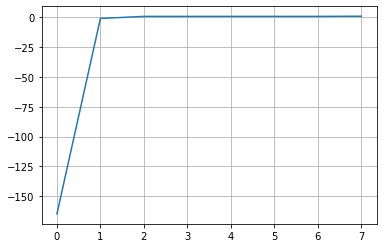

In [276]:
plt.plot(score_list)
plt.grid()

Малоинформативный график из-за первого значения, обрежем график:

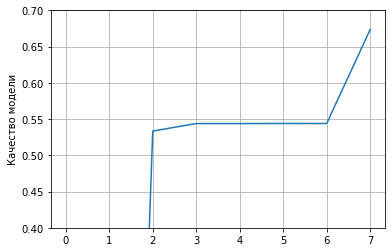

In [282]:
plt.plot(score_list)
plt.ylim(0.4, 0.7)
plt.grid()
plt.ylabel("Качество модели")
plt.show()